<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv  test-unbalanced.csv	train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

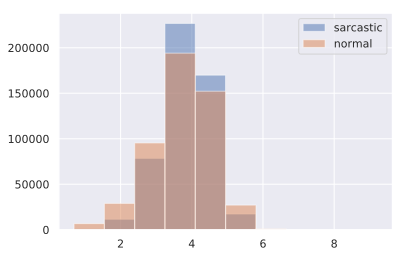

In [8]:
# plt.figure(figsize=(10,4))
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(alpha=.5, label='sarcastic')
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(alpha=.5, label='normal')
plt.legend()

In [9]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [10]:
sub_label = train_df.groupby("subreddit")['label'].agg([np.mean, np.sum, np.size])
sub_label.sort_values(by='sum', ascending=False).head(10)

,mean,sum,size
subreddit,,,
AskReddit,0.401453,26365,65674
politics,0.605348,23907,39493
worldnews,0.642516,16947,26376
leagueoflegends,0.542312,11407,21034
pcmasterrace,0.566651,10759,18987
news,0.603457,10193,16891
funny,0.451474,8099,17939
pics,0.484336,7823,16152
todayilearned,0.547567,7753,14159


In [11]:
sub_label[sub_label['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,mean,sum,size
subreddit,,,
creepyPMs,0.784303,4287,5466
MensRights,0.680775,2284,3355
ShitRedditSays,0.661994,850,1284
worldnews,0.642516,16947,26376
Libertarian,0.640125,1640,2562
atheism,0.639555,4718,7377
Conservative,0.639553,1203,1881
TwoXChromosomes,0.632692,987,1560
fatlogic,0.623090,1468,2356


for authors

In [12]:
author_label = train_df.groupby("author")['label'].agg([np.mean, np.sum, np.size])
author_label.sort_values(by='sum', ascending=False).head(10)

,mean,sum,size
author,,,
Biffingston,0.499408,422,845
pokemon_fetish,0.500000,216,432
NeonDisease,0.500000,211,422
ShyBiDude89,0.500000,202,404
ivsciguy,0.500000,171,342
mad-n-fla,0.500000,159,318
mindlessrabble,0.500000,151,302
Canada_girl,0.500000,150,300
Chaoslab,0.500000,126,252


In [13]:
author_label[author_label['size'] > 400].sort_values(by='mean', ascending=False).head(10)

,mean,sum,size
author,,,
NeonDisease,0.500000,211,422
ShyBiDude89,0.500000,202,404
pokemon_fetish,0.500000,216,432
Biffingston,0.499408,422,845


for scores

In [14]:
score_label = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.mean, np.sum, np.size])
score_label[score_label['size'] > 400].sort_values(by='mean', ascending=False).head(10)

,mean,sum,size
score,,,
0,0.612752,35626,58141
20,0.561370,1738,3096
34,0.556489,596,1071
26,0.554429,1039,1874
18,0.551759,2180,3951
13,0.546929,3980,7277
17,0.545867,2404,4404
40,0.545706,394,722
27,0.545351,956,1753


scores less than zero

In [15]:
score_label2 = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.mean, np.sum, np.size])
# score_label2.head(10)
score_label2[score_label2['size'] > 400].sort_values(by='mean', ascending=False).head(10)

,mean,sum,size
score,,,
-14,0.698324,375,537
-8,0.696004,1289,1852
-9,0.691284,1039,1503
-6,0.688795,2127,3088
-12,0.684278,531,776
-5,0.678520,2805,4134
-3,0.676069,4554,6736
-2,0.675948,8060,11924
-4,0.673473,3661,5436


In [16]:
print('Maximum score: ', train_df['score'].max(), '\n')
print('Minimum score: ', train_df['score'].min(), '\n')
print('Mean score: ', train_df['score'].mean(), '\n')
print('Standard Deviation score: ', train_df['score'].std(), '\n')
print('Median score: ', train_df['score'].median())

Maximum score:  9070 

Minimum score:  -507 

Mean score:  6.885999131357882 

Standard Deviation score:  48.34411298049262 

Median score:  2.0


In [17]:
max_score = train_df['score'].max()
min_score = train_df['score'].min()

parent_comment_max_score = train_df.loc[train_df['score'] == max_score, 'parent_comment'].iloc[0]
parent_comment_min_score = train_df.loc[train_df['score'] == min_score, 'parent_comment'].iloc[0]

comment_max_score = train_df.loc[train_df['score'] == max_score, 'comment'].iloc[0]
comment_min_score = train_df.loc[train_df['score'] == min_score, 'comment'].iloc[0]

sarcasm_max_score = train_df.loc[train_df['score'] == max_score, 'label'].iloc[0]
sarcasm_max_score = (sarcasm_max_score == 1)

sarcasm_min_score = train_df.loc[train_df['score'] == min_score, 'label'].iloc[0]
sarcasm_min_score = (sarcasm_min_score == 1)

print('The comment "{}", scored the highest at {}, had a parent comment of "{}" and it is labelled as sarcastic: {}'
      .format(comment_max_score, max_score, parent_comment_max_score, sarcasm_max_score), '\n')

print('The comment "{}", scored the lowest at {}, had a parent comment of "{}" and it is labelled as sarcastic: {}'
      .format(comment_min_score, min_score, parent_comment_min_score, sarcasm_min_score))

The comment "That's exactly what a country who made up a hoax about climate change would say!", scored the highest at 9070, had a parent comment of "China Tells Trump That Climate Change Is No Hoax It Invented" and it is labelled as sarcastic: True 

The comment "yes...the smiling is irrelevant when trying to tell if she is happy", scored the lowest at -507, had a parent comment of "She did the happy dance! Thats how you know shes happy :)" and it is labelled as sarcastic: True


In [18]:
train_df['date'] = pd.to_datetime(train_df['date'], yearfirst=True)
train_df['year'] = train_df['date'].apply(lambda d: d.year)
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,year
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12-01,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,2016


In [19]:
year_comments = train_df.groupby('year')['label'].agg([np.mean, np.size, np.sum])
year_comments.sort_values(by='sum', ascending=False).head(10)

,mean,size,sum
year,,,
2016,0.468334,475688,222781
2015,0.520460,286856,149297
2014,0.534542,137512,73506
2013,0.537981,63558,34193
2012,0.534368,27307,14592
2011,0.545783,12723,6944
2010,0.563933,5279,2977
2009,0.582703,1850,1078


Text(0,0.5,'Mean Sarcastic Comments by Year')

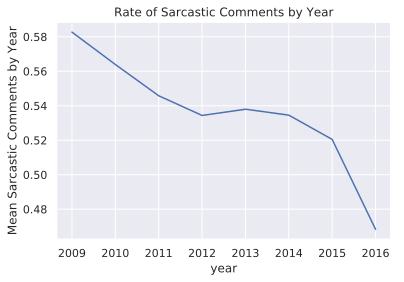

In [20]:
# plt.figure(figsize=(10,6))
year_comments['mean'].plot(kind='line')
plt.title('Rate of Sarcastic Comments by Year')
plt.ylabel('Mean Sarcastic Comments by Year')

In [21]:
X = train_df['comment']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) 

In [22]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features=60000, min_df=2)
logist = LogisticRegression(n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
tf_idf_logist_pipeline = Pipeline([('tf_idf', tf_idf),
                                  ('logist', logist)])

In [23]:
# fit
tf_idf_logist_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.8s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=60000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [24]:
# predict
pred = tf_idf_logist_pipeline.predict(X_test)

In [25]:
# accuracy
accuracy_score(y_test, pred)

0.7202735859012241

In [26]:
print('Accuracy score is: {:.2%}'.format(accuracy_score(y_test, pred)))

Accuracy score is: 72.03%


In [27]:
from sklearn.metrics import classification_report

In [28]:
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.71      0.76      0.73    151703\n           1       0.74      0.68      0.71    151529\n\n   micro avg       0.72      0.72      0.72    303232\n   macro avg       0.72      0.72      0.72    303232\nweighted avg       0.72      0.72      0.72    303232\n'

In [29]:
confusion_matrix(y_test, pred)

array([[114769,  36934],
       [ 47888, 103641]])

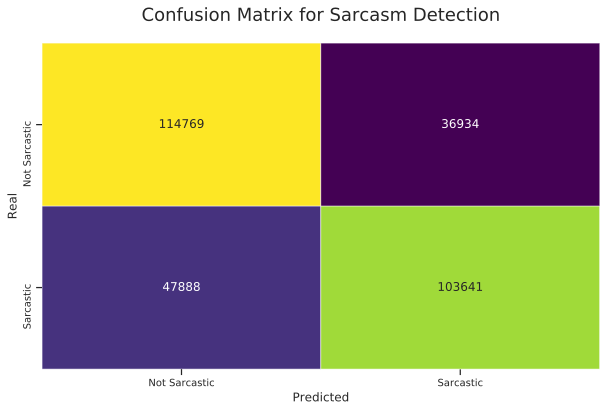

In [30]:
# plot confusion matrix
plt.figure(figsize=(10, 6))

conmat = pd.DataFrame(confusion_matrix(y_test, pred), index=['Not Sarcastic', 'Sarcastic'], 
                      columns=['Not Sarcastic', 'Sarcastic'])

ax = sns.heatmap(conmat, annot=True, cbar=False, cmap='viridis', linewidths=0.5, fmt='.0f')
ax.set_title('Confusion Matrix for Sarcasm Detection', fontsize=18, y=1.05)
ax.set_ylabel('Real', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_label_position('bottom')
ax.tick_params(labelsize=10)

In [31]:
import eli5

In [32]:
eli5.show_weights(estimator=tf_idf_logist_pipeline.named_steps['logist'], 
                  vec=tf_idf_logist_pipeline.named_steps['tf_idf'])

Weight?,Feature
+10.222,yes because
+7.843,clearly
+7.723,yeah because
+7.481,obviously
+6.926,totally
+6.162,because
+5.789,right because
+5.766,but thought
+5.731,how dare
+5.456,forgot


In [33]:
# using grid cv
from sklearn.model_selection import GridSearchCV

In [34]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit',LogisticRegression(solver='lbfgs', max_iter=3000))])
params = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}
grid = GridSearchCV(estimator=model, param_grid=params, verbose=1, n_jobs=-1, cv=3)

In [35]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [36]:
grid.best_params_

{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}

In [37]:
better_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2), use_idf=True)),
                    ('logit',LogisticRegression(solver='lbfgs', max_iter=3000))])
better_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [38]:
better_pred = better_model.predict(X_test)

In [39]:
accuracy_score(y_test, better_pred)

0.7238451086956522

In [40]:
print('Accuracy score is: {:.2%}'.format(accuracy_score(y_test, better_pred)))

Accuracy score is: 72.38%


> **slightly better accuracy**

In [41]:
confusion_matrix(y_test, better_pred)

array([[114573,  37130],
       [ 46609, 104920]])

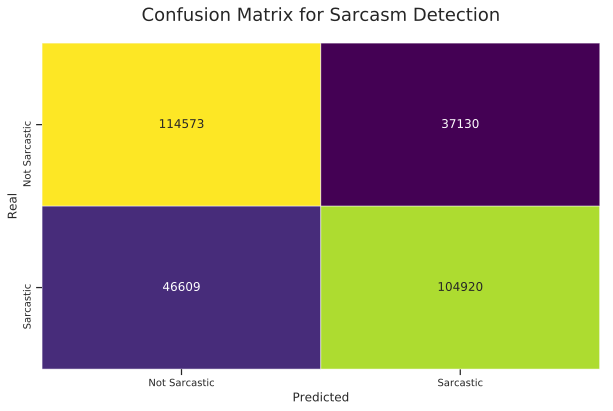

In [42]:
# plot confusion matrix again
plt.figure(figsize=(10, 6))

conmat = pd.DataFrame(confusion_matrix(y_test, better_pred), index=['Not Sarcastic', 'Sarcastic'], 
                      columns=['Not Sarcastic', 'Sarcastic'])

ax = sns.heatmap(conmat, annot=True, cbar=False, cmap='viridis', linewidths=0.5, fmt='.0f')
ax.set_title('Confusion Matrix for Sarcasm Detection', fontsize=18, y=1.05)
ax.set_ylabel('Real', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelsize=10)